# Application 2: Two body single channel nuclear scattering

Contributed by: Daniel Odell, Pablo Giuliani.

We have the following Hamiltonian as the radial part of the scattering equation:
\begin{equation}
    F_\alpha(\phi)=\left(-\frac{d^2}{dr^2}+\frac{\ell(\ell+1)}{r^2}+U(r,\alpha)-p^2\right)\phi(r)=0,
\end{equation}
where a system with reduced mass $\mu$ interacts through a potential $V(r,\alpha)=U(r,\alpha)/2\mu$ with parameters $\alpha$, $\ell$ is the angular momentum quantum number, and $p$ is the asymptotic linear momentum. Using an optical potential for $V(r,\alpha)$ this equation could model, for example, how neutrons interact with nuclei as we explained in the introduction section:
<img src="Fig1Scatt.png" alt="Fig. 1" style="width:350px;height:200px;">


We can re-scale this equation with the changes of variables $s=pr$ making it possible for us to apply the RBM across energies. We obtain the following equation:

\begin{equation}
    \left(-\frac{d^2}{ds^2}+\frac{\ell(\ell+1)}{s^2}+\tilde U(s,\alpha,p)-1\right)\phi_\alpha(s)=0,
\end{equation}
where the potential $\tilde U(s,\alpha,p)=V(s/p,\alpha)2\mu/p^2$ is now momentum dependent. We now proceed to construct a high fidelity solver for this equation which we will use to build a Reduced Basis using Principal Component Analysis, and later project with the Galerkin equaitons. As a first implementation, we will use the [Minnesota potential](https://linkinghub.elsevier.com/retrieve/pii/0375947477900070):

\begin{equation}
U(r,V_{0R},V_{0S})=2\mu\left(V_{0R}e^{-1.487r^2}+ V_{0S}e^{-0.465r^2}\right),
\end{equation}

where the parameters are $\alpha=[V_{0R},V_{0S}]$. We have kept the non-linear parameter dependence of the potential (the coefficients multiplying $r^2$ on the exponentials) fixed on their original values. We will vary them in the next section when we explore the Empirical Interpolation Method (see chapter V of [this book](https://link.springer.com/book/10.1007/978-3-319-22470-1)). We also work with the S wave ($l=0$) in this example.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# plt.style.use('science')

#Defining a couple of aesthetic parameters
gr = (1 + np.sqrt(5)) / 2
h = 3

In [2]:
hbarc = 197 # MeV • fm
mass = 939 # MeV
energy = 50 # center-of-mass scattering energy, fixed for the first example
k = np.sqrt(mass*energy)/hbarc
l = 0 # S waves

# interaction parameters we will use for testing
v0r = 200
v0s = -91.85

def mn_potential(r, args):
    '''
    Minnesota potential
    '''
    v_0r, v_0s = args
    return v_0r * np.exp(-1.487*r**2) + v_0s*np.exp(-0.465*r**2)


def mn_potential_tilde(s, args):
    '''
    Energy-scaled Minnesota potential
    s = rho = kr
    '''
    return 1/energy * mn_potential(s/k, args)


## High fidelity solver

In [23]:
initial_conditions = np.array([0.0, 1.0]) # initial phi(0) and phi'(0) conditions
s_endpts = k * np.array([1e-6, 20]) # dimensionless

s_mesh = np.linspace(*s_endpts, 2000)


def solve_se(theta):
    result = solve_ivp(
        lambda s, phi: np.array([phi[1],
            (mn_potential_tilde(s, theta) + l*(l+1)/s**2 - 1.0) * phi[0]]),
        s_endpts, initial_conditions, rtol=1e-12, atol=1e-12, dense_output=True
    )
    phi = result.sol(s_mesh)[0, :]
#     c = np.max(np.abs(phi))
#     return s_mesh, phi/c
    return s_mesh, phi

The figure above shows the high-fidelity solution, obtained by numerically integrating the initial conditions from $r=0$.

## Training the Reduced Basis

In [24]:
#We create 10 random values of the linear parameters and solve the high fidelity problem 10 times

training_points = np.array([
    [119.51219512195122, -14.634146341463415],
    [139.02439024390245, -4.878048780487805],
    [158.53658536585365, -48.78048780487805],
    [178.0487804878049, -117.07317073170732],
    [197.5609756097561, -131.70731707317074],
    [217.0731707317073, -126.82926829268293],
    [236.58536585365854, -82.92682926829268],
    [256.0975609756098, -175.609756097561],
    [275.609756097561, -19.51219512195122],
    [295.1219512195122, -170.73170731707316]
])

training_solutions = np.array(
    [solve_se(theta)[1] for theta in training_points]
).T


And this is how they all look like:

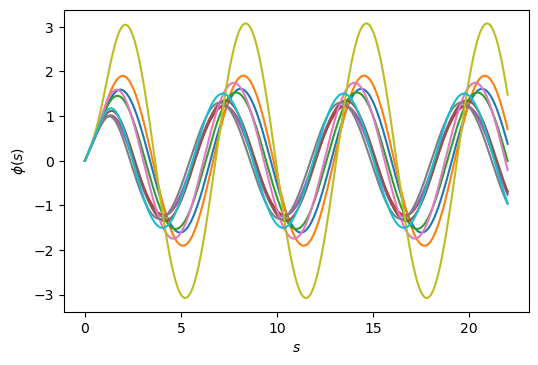

In [25]:
fig, ax = plt.subplots(dpi=100)
fig.patch.set_facecolor('white')

for u in training_solutions.T:
    ax.plot(s_mesh, u)

ax.set_ylabel(r'$\phi(s)$')
ax.set_xlabel(r'$s$');

Lets go for a Principal Component Analysis/Singular Value Decomposition

In [26]:
U, S, Vt = np.linalg.svd(training_solutions, full_matrices=False)

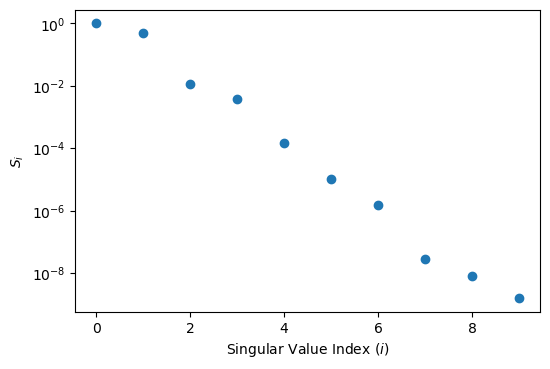

In [27]:
fig, ax = plt.subplots(dpi=100)
fig.patch.set_facecolor('white')

ax.scatter(np.arange(S.size), S/S[0])

ax.set_yscale('log')
ax.set_xlabel(r'Singular Value Index ($i$)')
ax.set_ylabel(r'$S_i$');

The singular values indeed decay exponentially, indicating that a RBM emulation is probable to be succesful. It is interesting to note that the second singular value is higher than what one might initially expect. This is because outside of the potential region, the solution can be expressed in general as a linear combination of two orthogonal independent functions (related to sines and cosines), which is why in this case the second component is particularly important. The overall pattern of the singular value has this zig-zag (or stairs) pattern because of this reason.

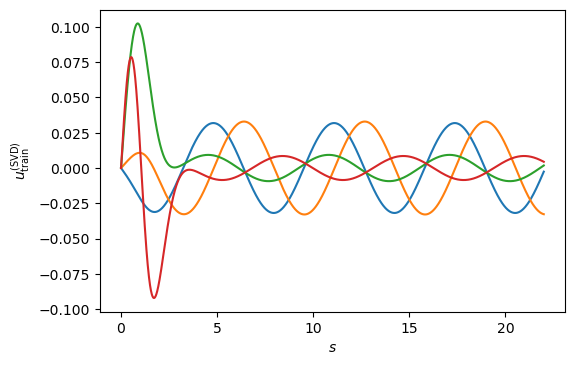

In [28]:
#We select four basis and obtain the following gorgeous functions:
nbasis = 4

fig, ax = plt.subplots(dpi=100)
fig.patch.set_facecolor('white')

for i in range(nbasis):
    ax.plot(s_mesh, U[:, i])

ax.set_xlabel(r'$s$')
ax.set_ylabel(r'$u_{\rm train}^{({\rm SVD})}$');

Very interestingly, if we were to now use this as our reduced basis, our projection equations will give us the solution constantly equal to zero $\hat \phi(r) =0$ and $a_k=0$. The reason is that the scattering problem is homogeneous in the function $\phi$ (the function zero is a valid solution). To get around this, we could impose a boundary condition, for example the asymptotic normalizations used in similar emulator papers (see [this one](https://www.sciencedirect.com/science/article/pii/S0370269320305220) and [this one](https://www.sciencedirect.com/science/article/pii/S0370269321007176)). 

Another way around it is to use the $\phi_0$ component avaialble in the RB expansion (look [here](https://arxiv.org/abs/2203.05284v2) for details):

\begin{equation}
    \phi \approx \hat\phi = \phi_0 + \sum_k^n a_k \phi_k
\end{equation}

We follow this approach by selecting $\phi_0$ as the free solution in the abscence of any potential. We re-define our principal components as the differences between this free solution and the high fidelity solutions for the different parameter values.

In [29]:
phi_0 = solve_se(np.array([0, 0]))[1]

training_solutions_sub = np.zeros_like(training_solutions.T)

for i in range(training_solutions.shape[1]):
    training_solutions_sub[i,:] = training_solutions.T[i,:].copy() - phi_0
    



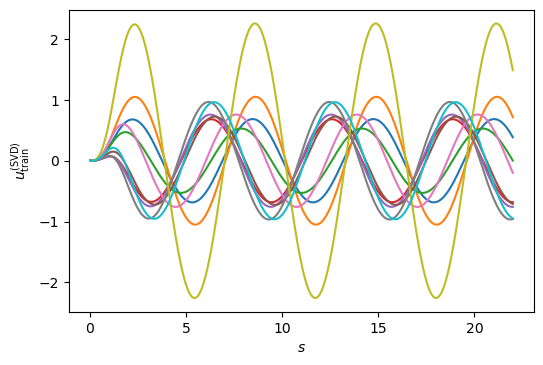

In [31]:
fig, ax = plt.subplots(dpi=100)
fig.patch.set_facecolor('white')

for i in range(len(training_solutions_sub)):
    ax.plot(s_mesh, training_solutions_sub[i,:])

ax.set_xlabel(r'$s$')
ax.set_ylabel(r'$u_{\rm train}^{({\rm SVD})}$');

In [32]:
U, S, Vt = np.linalg.svd(training_solutions_sub.T, full_matrices=False)

In [33]:
utilde = mn_potential_tilde(s_mesh, [v0r, v0s])[:, np.newaxis]

In [34]:
basis = U[:, :nbasis] # Galerkin basis
psi = U[:, :nbasis] # judges
d2 = np.gradient(np.gradient(basis, s_mesh, axis=0), s_mesh, axis=0) # second derivative

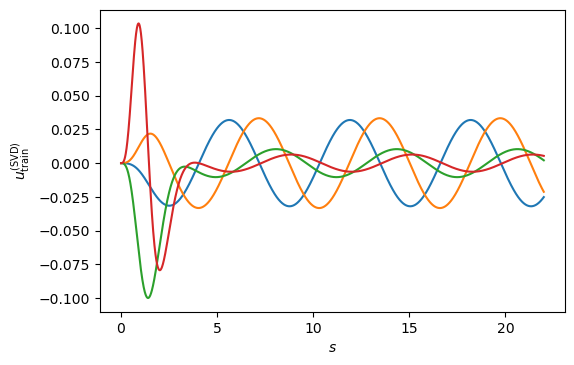

In [35]:
fig, ax = plt.subplots(dpi=100)
fig.patch.set_facecolor('white')

for i in range(nbasis):
    ax.plot(s_mesh, basis[:,i])

ax.set_xlabel(r'$s$')
ax.set_ylabel(r'$u_{\rm train}^{({\rm SVD})}$');

Now our new RB has by construction a zero derivative at $s=0$, the normalization condition of $\phi'(s=0)=1$ is entirely carried out by the $\phi_0$ term. Our Galerkin equations look like:

\begin{equation}
    \langle \psi_j | F(\hat\phi) \rangle = \langle \psi_j | F(\phi_0) \rangle + \sum_k ^n a_k\langle \psi_j | F(\phi_k) \rangle =0
\end{equation}

These $n$ ($j$ goes from 1 to $n$) equations can be written in a matrix form $Aa=b$, where $a=(a_1,a_2,...a_n)$, the matrix $A$ is form by the inner products between the projectors $\langle\psi_k|$ and the operator $F_\alpha$ acting on each one of the basis $|\phi_k\rangle$, and $b$ is the non-homogenous term obtaining from the projection of $F_\alpha(\phi_0)$ onto the $\psi_j$. This last term acts, in some sense, as a "source" for creating the non-homogenous solution to the approximated differential scattering equation through $F_\alpha$, which has information on the parameters $\alpha$.

Lets put all this into code and solve for the coefficients!

In [45]:
A_right = -d2 + utilde * basis - basis
A = psi.T @ A_right
b = -psi.T @ (-np.gradient(np.gradient(phi_0, s_mesh), s_mesh) + utilde.T[0]*phi_0 - phi_0)
a = np.linalg.solve(A, b)
emu = np.sum(a * basis, axis=1)+phi_0

In [46]:
a

array([ 2.97232314, 16.30316717,  0.35056666, -0.02741656])

In [47]:
exact = solve_se([v0r, v0s])[1]

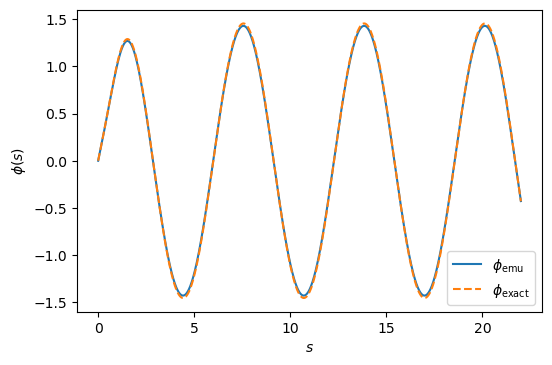

In [48]:
fig, ax = plt.subplots(dpi=100)
fig.patch.set_facecolor('white')

ax.plot(s_mesh, emu, linestyle='-', label=r'$\phi_{\rm emu}$')
ax.plot(s_mesh, exact, linestyle='--', label=r'$\phi_{\rm exact}$')

ax.set_xlabel(r'$s$')
ax.set_ylabel(r'$\phi(s)$')
ax.legend();

Looks gorgeous doesn't it?

Now, there are many extensions we can explore to the approach we just did. In the following two sections we explore how to "linearize" the potential $V_\alpha$ when the dependence on the parameters is non-linear through the Empirical Interpolation Method. This will also allow us to emulating the solutions across different energies, since the dependence of the re-scaled potential in the energy is non-linear.